# Social Data Analysis and Visualization Final Project
# Coronavirus-19 analysis and comparison with other pandemics

## 1. Motivation

### What is your dataset?

In our project we used four different datasets: [H1N1 dataset](https://www.kaggle.com/de5d5fe61fcaa6ad7a66/pandemic-2009-h1n1-swine-flu-influenza-a-dataset), [Ebola dataset](https://www.kaggle.com/imdevskp/ebola-outbreak-20142016-complete-dataset) and [SARS 2003](https://www.kaggle.com/imdevskp/sars-outbreak-2003-complete-dataset), all of them acquired from [Kaggle](https://www.kaggle.com/). We also use a daily updated API for the Coronavirus data.

### Why did you choose this/these particular dataset(s)?

First of all, we wanted to have the newest data for the Coronavirus and this is why we chose to use the API. Regarding the other three pandemics, these were the datasets we found and they include the basic stats we need for our analysis.

### What was your goal for the end user's experience?

Our goal it to analyze the three pandemics, H1N1, Ebola and SARS 2003, in order to find common points with Coronavirus. At first glance, those four pandemics do not seem to have something in common, however an analysis might show us something different. If we find common point, we want to show the users that this might help understand Coronavirus better. If not, we will continue analysis on Coronavirus, show the users how it spread and the countries most affected and why and finally try to forecast the future of it.

## 2. Basic stats
### Write about your choices in data cleaning and preprocessing

### Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis

## 3. Data Analysis
### Describe your data analysis and explain what you've learned about the dataset

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import bokeh 
from bokeh.core.properties import value
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.transform import dodge
from bokeh.models import Legend
from math import pi
from geopy.geocoders import Nominatim
import requests
import random
from IPython.display import display, HTML
import folium
from folium.plugins import Fullscreen, HeatMapWithTime, TimestampedGeoJson
from folium.plugins import TimestampedGeoJson

#### Useful Functions

In [2]:
def calcCumulativeCases(df):
    return df.groupby(['Country'])['Cases'].cumsum().astype('int')

def calcCumulativeDeaths(df):
    return df.groupby(['Country'])['Deaths'].cumsum().astype('int')

In [3]:
def assignLatLon(df):  
    geolocator = Nominatim()
    countryLatLon = {}
    countries = df.Country.unique()
    for country in countries:
        location = geolocator.geocode(country, timeout=10)
        try:
            countryLatLon[country] = (location.latitude, location.longitude)
        except:
            countryInRegion = country.split(",")[0]
            if (countryInRegion not in countries and countryInRegion is not "Netherlands Antilles"):
                location = geolocator.geocode(countryInRegion, timeout=10)
                try:
                    countryLatLon[country] = (location.latitude, location.longitude)
                except:
                    print("Unknown location:", country)
                    countryLatLon[country] = (90,0)
            elif (countryInRegion is "Netherlands Antilles"):
                location = geolocator.geocode(country.split(",")[1], timeout=10)
                try:
                    countryLatLon[country] = (location.latitude, location.longitude)
                except:
                    print("Unknown location:", country)
                    countryLatLon[country] = (90,0)
            elif (',' in countryInRegion):
                location = geolocator.geocode(country.split(",")[0], timeout=10)
                try:
                    countryLatLon[country] = (location.latitude, location.longitude)
                except:
                    print("Unknown location:", country)
                    countryLatLon[country] = (90,0)
            else:
                print("Unknown location:", country)
                countryLatLon[country] = (90,0)
    print('Done with LatLon obj')
    for index, row in df.iterrows():
        df.loc[index, "Latitude"] = countryLatLon[row["Country"]][0]
        df.loc[index, "Longitude"] = countryLatLon[row["Country"]][1]
    return df

In [4]:
def plotMap(df):
    Map = folium.Map(location=(0,0), zoom_start=2)
    countries = df.Country.unique()
    for country in countries:
        totalCases = df[df["Country"] == country].CumulativeCases.max()
        locationCenter = (df[df["Country"] == country].Latitude.max(), df[df["Country"] == country].Longitude.max())
        Map.add_child(folium.CircleMarker(location=locationCenter, radius=1, tooltip="{}: {}".format(country, totalCases), popup="popup"))
    display(Map)

In [5]:
def create_geojson_features(df):
    print('> Creating GeoJSON features...')
    features = []
    for index, row in df.iterrows():
        if ((row['Date']) is np.NaN): print(index)
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['Longitude'],row['Latitude']]
            },
            'properties': {
                'time': pd.to_datetime(row['Date']).date().__str__(),
                'style': {'color' : "red"},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': "red",
                    'fillOpacity': 0.1,
                    'stroke': 'true',
                    'radius': 1
                }
            }
        }
        features.append(feature)
    return features

In [6]:
def make_map(features):
    print('> Making map...')
    coords=[0, 0]
    Map = folium.Map(location=coords, control_scale=True, zoom_start=2)

    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='P1D'
        , add_last_point=True
        , auto_play=False
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY/MM/DD'
        , time_slider_drag_update=True
    ).add_to(Map)
    print('> Done.')
    display(Map)

In [7]:
def plotHeatMapWithTime(df):
    Map = folium.Map(location=(0,0), zoom_start=2)
    df = df.sort_values("Date")
    lastMonth = df.Date.unique()[-31:]
    
    locations = [[[row['Y'],row['X']] for index, row in df[int(df['Date'].split("-")[2]) == i].iterrows()] for i in range(1,32)]
    print('Last month of pandemic')
    Map.add_child(plugins.Fullscreen(position='topleft', force_separate_button=True))
    Map.add_child(plugins.MiniMap())
    HeatMapWithTime(locations, max_speed=1, auto_play=True).add_to(map_city)
    map_city

#### H1N1

In [8]:
h1n1 = pd.read_csv('Pandemic (H1N1) 2009.csv', encoding = 'latin')
h1n1 = h1n1.rename(columns={"Update Time": "UpdateTime"})
h1n1['Date'] = pd.to_datetime(h1n1['UpdateTime']).dt.date
h1n1

,Country,Cases,Deaths,UpdateTime,Date
0,Algeria,5,0.0,7/6/2009 9:00,2009-07-06
1,Antigua and Barbuda,2,0.0,7/6/2009 9:00,2009-07-06
2,Argentina,2485,60.0,7/6/2009 9:00,2009-07-06
3,Australia,5298,10.0,7/6/2009 9:00,2009-07-06
4,Austria,19,0.0,7/6/2009 9:00,2009-07-06
...,...,...,...,...,...
1817,Thailand,2,0.0,5/23/2009 8:00,2009-05-23
1818,Turkey,2,0.0,5/23/2009 8:00,2009-05-23
1819,United Kingdom,117,0.0,5/23/2009 8:00,2009-05-23
1820,United States of America,6552,9.0,5/23/2009 8:00,2009-05-23


In [9]:
# check for missing values 
h1n1.isna().sum() 

Country       0
Cases         0
Deaths        1
UpdateTime    0
Date          0
dtype: int64

In [10]:
# fill nan value with interpolation 
h1n1["Deaths"] = h1n1["Deaths"].interpolate(method ='linear', limit_direction ='forward') 

In [11]:
casesperday = h1n1.groupby('Date').Cases.sum()
casesperday = pd.DataFrame({'Date':casesperday.index, 'Count':casesperday.values})
deathsperday = h1n1.groupby('Date').Deaths.sum()
deathsperday = pd.DataFrame({'Date':deathsperday.index, 'Count':deathsperday.values})

In [12]:
# find the duration of the pandemic 
start = h1n1['Date'].min()
end = h1n1['Date'].max()
duration = end - start
print('The duration of H1N1 pandemic was: ' + str(duration))

The duration of H1N1 pandemic was: 44 days, 0:00:00


In [13]:
# get statistics for count, mean, min and max daily cases
h1n1[['Country', 'Date', 'Cases', 'Deaths']].groupby(['Country']).agg(['count', 'mean', 'min', 'max'])

Cases                        Deaths                 \
                        count         mean min   max  count      mean  min   
Country                                                                      
Algeria                     7     2.714286   1     5      7  0.000000  0.0   
Antigua and Barbuda         6     2.000000   2     2      6  0.000000  0.0   
Argentina                  22   646.954545   1  2485     22  7.954545  0.0   
Australia                  22  1795.318182  12  5298     22  1.772727  0.0   
Austria                    22     6.772727   1    19     22  0.000000  0.0   
...                       ...          ...  ..   ...    ...       ...  ...   
     Netherlands, Aruba     2     5.000000   5     5      2  0.000000  0.0   
     New Caledonia, FOC     1    12.000000  12    12      1  0.000000  0.0   
     Puerto Rico            1    18.000000  18    18      1  0.000000  0.0   
     Saint Martin, FOC      1     1.000000   1     1      1  0.000000  0.0   
     Virgin Islands         1     1.000000   1     1      1  0.000000  0.0   

                               
                          max  
Country                        
Algeria                   0.0  
Antigua and Barbuda       0.0  
Argentina                60.0  
Australia                10.0  
Austria                   0.0  
...                       ...  
     Netherlands, Aruba   0.0  
     New Caledonia, FOC   0.0  
     Puerto Rico          0.0  
     Saint Martin, FOC    0.0  
     Virgin Islands       0.0  

[152 rows x 8 columns]

#### Ebola

In [14]:
ebola = pd.read_csv('ebola_2014_2016_clean.csv', encoding = 'latin')
ebola = ebola.rename(columns={"No. of confirmed cases": "Cases", "No. of confirmed deaths": "Deaths"})
ebola['Date'] = pd.to_datetime(ebola['Date']).dt.date
ebola

,Country,Date,No. of suspected cases,No. of probable cases,Cases,"No. of confirmed, probable and suspected cases",No. of suspected deaths,No. of probable deaths,Deaths,"No. of confirmed, probable and suspected deaths"
0,Guinea,2014-08-29,25.0,141.0,482.0,648.0,2.0,141.0,287.0,430.0
1,Nigeria,2014-08-29,3.0,1.0,15.0,19.0,0.0,1.0,6.0,7.0
2,Sierra Leone,2014-08-29,54.0,37.0,935.0,1026.0,8.0,34.0,380.0,422.0
3,Liberia,2014-08-29,382.0,674.0,322.0,1378.0,168.0,301.0,225.0,694.0
4,Sierra Leone,2014-09-05,78.0,37.0,1146.0,1261.0,11.0,37.0,443.0,491.0
...,...,...,...,...,...,...,...,...,...,...
2480,Liberia,2016-03-23,5636.0,1879.0,3151.0,10666.0,NaN,NaN,NaN,4806.0
2481,Italy,2016-03-23,0.0,0.0,1.0,1.0,NaN,NaN,NaN,0.0
2482,Liberia,2016-03-23,0.0,3.0,2.0,5.0,NaN,3.0,1.0,4.0
2483,Nigeria,2016-03-23,0.0,1.0,19.0,20.0,0.0,1.0,7.0,8.0


In [15]:
# check for missing values 
ebola.isna().sum() 

Country                                               0
Date                                                  0
No. of suspected cases                              119
No. of probable cases                                49
Cases                                                 1
No. of confirmed, probable and suspected cases        8
No. of suspected deaths                            1177
No. of probable deaths                              959
Deaths                                              837
No. of confirmed, probable and suspected deaths       0
dtype: int64

In [16]:
# fill missing values in cases and deaths
ebola["Cases"] = ebola["Cases"].interpolate(method ='linear', limit_direction ='forward') 
ebola["Deaths"] = ebola["Deaths"].interpolate(method ='linear', limit_direction ='forward') 

In [17]:
casesperday_ebola = ebola.groupby('Date').Cases.sum()
casesperday_ebola = pd.DataFrame({'Date':casesperday_ebola.index, 'Count':casesperday_ebola.values})
deathsperday_ebola = ebola.groupby('Date').Deaths.sum()
deathsperday_ebola = pd.DataFrame({'Date':deathsperday_ebola.index, 'Count':deathsperday_ebola.values})

In [18]:
# find the duration of the pandemic 
start_ebola = ebola['Date'].min()
end_ebola = ebola['Date'].max()
duration_ebola = end_ebola - start_ebola
print('The duration of Ebola pandemic was: ' + str(duration_ebola))

The duration of Ebola pandemic was: 572 days, 0:00:00


In [19]:
# get statistics for count, mean, min and max daily cases
ebola[['Country', 'Date', 'Cases', 'Deaths']].groupby(['Country']).agg(['count', 'mean', 'min', 'max'])

Cases                             Deaths  \
                         count         mean    min     max  count   
Country                                                             
Guinea                     259  2894.293436  482.0  3351.0    259   
Italy                      141     1.000000    1.0     1.0    141   
Liberia                    365  2110.213699    2.0  3153.0    365   
Mali                       243     6.823045    1.0     7.0    243   
Nigeria                    255    18.980392   15.0    19.0    255   
Senegal                    254     1.000000    1.0     1.0    254   
Sierra Leone               259  7883.671815  935.0  8704.0    259   
Spain                      243     1.000000    1.0     1.0    243   
United Kingdom             221     1.000000    1.0     1.0    221   
United States of America   245     3.946939    1.0     4.0    245   

                                                              
                                 mean       min          max  
Country                                                       
Guinea                    1780.758687  0.500000  2083.000000  
Italy                      884.147872  0.000000  3589.000000  
Liberia                    609.848584  0.000000  3858.000000  
Mali                       821.623868  0.000000  3503.666667  
Nigeria                      6.996078  6.000000     7.000000  
Senegal                      0.000000  0.000000     0.000000  
Sierra Leone              3081.032175  0.333333  3589.000000  
Spain                        0.000000  0.000000     0.000000  
United Kingdom             991.633409  0.000000  3501.333333  
United States of America     0.987755  0.000000     1.000000

#### SARS

In [20]:
sars = pd.read_csv('sars_2003_complete_dataset_clean.csv', encoding = 'latin')
sars['Date'] = pd.to_datetime(sars['Date']).dt.date
sars = sars.rename(columns={"Cumulative number of case(s)": "Cases", "Number of deaths": "Deaths", "Number recovered": "Recovered" })
sars

,Date,Country,Cases,Deaths,Recovered
0,2003-03-17,Germany,1,0,0
1,2003-03-17,Canada,8,2,0
2,2003-03-17,Singapore,20,0,0
3,2003-03-17,"Hong Kong SAR, China",95,1,0
4,2003-03-17,Switzerland,2,0,0
...,...,...,...,...,...
2533,2003-07-11,Switzerland,1,0,1
2534,2003-07-11,Thailand,9,2,7
2535,2003-07-11,United Kingdom,4,0,4
2536,2003-07-11,United States,75,0,67


In [21]:
# check for missing values 
sars.isna().sum() 

Date         0
Country      0
Cases        0
Deaths       0
Recovered    0
dtype: int64

In [22]:
casesperday_sars = sars.groupby('Date').Cases.sum()
casesperday_sars = pd.DataFrame({'Date':casesperday_sars.index, 'Count':casesperday_sars.values})
deathsperday_sars = sars.groupby('Date').Deaths.sum()
deathsperday_sars = pd.DataFrame({'Date':deathsperday_sars.index, 'Count':deathsperday_sars.values})

In [23]:
# find the duration of the pandemic 
start_sars = sars['Date'].min()
end_sars = sars['Date'].max()
duration_sars = end_sars - start_sars
print('The duration of SARS 2003 pandemic was: ' + str(duration_sars))

The duration of SARS 2003 pandemic was: 116 days, 0:00:00


In [24]:
# get statistics for count, mean, min and max daily cases
sars[['Country', 'Date', 'Cases', 'Deaths']].groupby(['Country']).agg(['count', 'mean', 'min', 'max'])

Cases                        Deaths                     
                     count         mean min   max  count        mean min  max
Country                                                                      
Australia               17     2.882353   1     6     17    0.000000   0    0
Belgium                  5     1.000000   1     1      5    0.000000   0    0
Brazil                  81     2.000000   1     3     81    0.000000   0    0
Bulgaria                20     1.000000   1     1     20    0.000000   0    0
Canada                  96   148.427083   8   252     96   20.989583   2   38
China                   96  3573.885417   0  5329     96  205.604167   0  348
Colombia                53     1.000000   1     1     53    0.000000   0    0
Finland                 51     1.000000   1     1     51    0.000000   0    0
France                  90     5.600000   1     7     90    0.011111   0    1
Germany                 96     7.552083   1    10     96    0.000000   0    0
Hong Kong SAR, China    96  1383.083333  95  1755     96  176.291667   1  298
India                   64     2.468750   1     3     64    0.000000   0    0
Indonesia               72     1.805556   1     2     72    0.000000   0    0
Italy                   92     6.271739   1     9     92    0.000000   0    0
Japan                   19     2.368421   1     5     19    0.000000   0    0
Kuwait                  75     1.000000   1     1     75    0.000000   0    0
Macao SAR, China        58     1.103448   1     2     58    0.000000   0    0
Malaysia                79     5.316456   1     8     79    1.810127   1    2
Mongolia                69     7.985507   3     9     69    0.000000   0    0
New Zealand             56     1.000000   1     1     56    0.000000   0    0
Philippines             72     9.750000   1    14     72    1.763889   0    2
Poland                  10     1.000000   1     1     10    0.000000   0    0
Republic of Ireland     92     1.076087   1     2     92    0.000000   0    0
Republic of Korea       59     2.593220   1     3     59    0.000000   0    0
Romania                 87     1.137931   1     3     87    0.000000   0    0
Russian Federation      31     1.000000   1     1     31    0.000000   0    0
Singapore               96   171.125000  20   206     96   21.375000   0   32
Slovenia                 5     1.000000   1     1      5    0.000000   0    0
South Africa            74     1.000000   1     1     74    0.729730   0    1
Spain                   86     1.000000   1     1     86    0.000000   0    0
Sweden                  72     2.888889   1     3     72    0.000000   0    0
Switzerland             94     1.351064   1     7     94    0.000000   0    0
Taiwan, China           95   319.715789   3   698     95   37.368421   0   84
Thailand                96     7.260417   1     9     96    1.739583   0    2
United Kingdom          95     4.357895   1     6     95    0.000000   0    0
United States           94    76.659574  11   220     94    0.000000   0    0
Viet Nam                95    61.947368  40    63     95    4.610526   1    5

#### COVID-19

In [25]:
URL = "https://wuhan-coronavirus-api.laeyoung.endpoint.ainize.ai/jhu-edu/timeseries"
r = requests.get(url = URL)
data = r.json()
data

[{'provincestate': '',
  'countryregion': 'Afghanistan',
  'lastupdate': '2020-04-27T08:42:00.003Z',
  'location': {'lat': 33, 'lng': 65},
  'countrycode': {'iso2': 'AF', 'iso3': 'AFG'},
  'timeseries': {'1/22/20': {'confirmed': 0, 'deaths': 0, 'recovered': 0},
   '1/23/20': {'confirmed': 0, 'deaths': 0, 'recovered': 0},
   '1/24/20': {'confirmed': 0, 'deaths': 0, 'recovered': 0},
   '1/25/20': {'confirmed': 0, 'deaths': 0, 'recovered': 0},
   '1/26/20': {'confirmed': 0, 'deaths': 0, 'recovered': 0},
   '1/27/20': {'confirmed': 0, 'deaths': 0, 'recovered': 0},
   '1/28/20': {'confirmed': 0, 'deaths': 0, 'recovered': 0},
   '1/29/20': {'confirmed': 0, 'deaths': 0, 'recovered': 0},
   '1/30/20': {'confirmed': 0, 'deaths': 0, 'recovered': 0},
   '1/31/20': {'confirmed': 0, 'deaths': 0, 'recovered': 0},
   '2/1/20': {'confirmed': 0, 'deaths': 0, 'recovered': 0},
   '2/2/20': {'confirmed': 0, 'deaths': 0, 'recovered': 0},
   '2/3/20': {'confirmed': 0, 'deaths': 0, 'recovered': 0},
   '2/4/2

In [26]:
cols = ['Country','Province_State','Last_Update','Date','Latitude','Longitude', 'Confirmed', 'Deaths', 'Recovered']
corona = pd.DataFrame(columns=cols)

for i in range(len(data)):
    for j in data[i]['timeseries'].keys():
        corona = corona.append({'Country':data[i]['countryregion'],
                'Province_State':data[i]['provincestate'],
                'Last_Update':data[i]['lastupdate'],
                'Latitude':data[i]['location']['lat'],
                'Longitude':data[i]['location']['lng'],
                'Date': j,
                'Confirmed':data[i]['timeseries'][j].get('confirmed'),
                'Deaths':data[i]['timeseries'][j].get('deaths'),
                'Recovered':data[i]['timeseries'][j].get('recovered')}, ignore_index=True)
# display(HTML(corona.to_html()))

In [27]:
corona = corona.rename(columns={"Confirmed": "Cases"})

In [28]:
# latitude and longtitude are according to province
corona['Date'] = pd.to_datetime(corona['Date']).dt.date
corona['Last_Update'] = pd.to_datetime(corona['Last_Update']).dt.date
corona = corona[['Country', 'Province_State', 'Date', 'Latitude', 'Longitude', 'Cases', 'Deaths', 'Recovered']]
corona.sort_values(by=['Date', 'Cases'], ascending=[True, False], inplace=True)
corona = corona.reset_index(drop=True)
corona.head()

,Country,Province_State,Date,Latitude,Longitude,Cases,Deaths,Recovered
0,China,Hubei,2020-01-22,30.9756,112.271,444,17,28
1,China,Guangdong,2020-01-22,23.3417,113.424,26,0,0
2,China,Beijing,2020-01-22,40.1824,116.414,14,0,0
3,China,Zhejiang,2020-01-22,29.1832,120.093,10,0,0
4,China,Shanghai,2020-01-22,31.202,121.449,9,0,0


In [29]:
corona['Cases'] = pd.to_numeric(corona['Cases'])
corona['Deaths'] = pd.to_numeric(corona['Deaths'])
corona['Recovered'] = pd.to_numeric(corona['Recovered'])
corona['Latitude'] = pd.to_numeric(corona['Latitude'])
corona['Longitude'] = pd.to_numeric(corona['Longitude'])

In [30]:
# check for missing values 
corona.isna().sum() 

Country            0
Province_State     0
Date               0
Latitude           0
Longitude          0
Cases             96
Deaths            96
Recovered          0
dtype: int64

In [31]:
# fill nan value with interpolation
corona["Cases"] = corona["Cases"].interpolate(method ='linear', limit_direction ='forward')
corona["Deaths"] = corona["Deaths"].interpolate(method ='linear', limit_direction ='forward') 

In [32]:
casesperday_corona = corona.groupby('Date').Cases.sum()
casesperday_corona = pd.DataFrame({'Date':casesperday_corona.index, 'Count':casesperday_corona.values})
deathsperday_corona = corona.groupby('Date').Deaths.sum()
deathsperday_corona = pd.DataFrame({'Date':deathsperday_corona.index, 'Count':deathsperday_corona.values})

In [33]:
# find the duration of the pandemic 
start_corona = corona['Date'].min()
end_corona = corona['Date'].max()
duration_corona = end_corona - start_corona
print('The duration of Coronavirus 2019 pandemic is: ' + str(duration_corona))

The duration of Coronavirus 2019 pandemic is: 95 days, 0:00:00


In [34]:
# get statistics for count, mean, min and max daily cases
corona[['Country', 'Date', 'Cases', 'Deaths']].groupby(['Country']).agg(['count', 'mean', 'min', 'max'])

Cases                          Deaths                  \
                   count        mean  min     max  count       mean  min   
Country                                                                    
Afghanistan           96  216.885417  0.0  1531.0     96   6.770833  0.0   
Albania               96  154.572917  0.0   726.0     96   7.291667  0.0   
Algeria               96  617.760417  0.0  3382.0     96  80.812500  0.0   
Andorra               96  197.072917  0.0   738.0     96   8.239583  0.0   
Angola                96    5.635417  0.0    26.0     96   0.604167  0.0   
...                  ...         ...  ...     ...    ...        ...  ...   
West Bank and Gaza    96  102.312500  0.0   484.0     96   0.614583  0.0   
Western Sahara        96    1.229167  0.0     6.0     96   0.000000  0.0   
Yemen                 96    0.177083  0.0     1.0     96   0.000000  0.0   
Zambia                96   16.270833  0.0    88.0     96   0.520833  0.0   
Zimbabwe              96    5.572917  0.0    31.0     96   0.822917  0.0   

                           
                      max  
Country                    
Afghanistan          50.0  
Albania              28.0  
Algeria             425.0  
Andorra              40.0  
Angola                2.0  
...                   ...  
West Bank and Gaza    4.0  
Western Sahara        0.0  
Yemen                 0.0  
Zambia                3.0  
Zimbabwe              4.0  

[184 rows x 8 columns]

#### Data Distribution

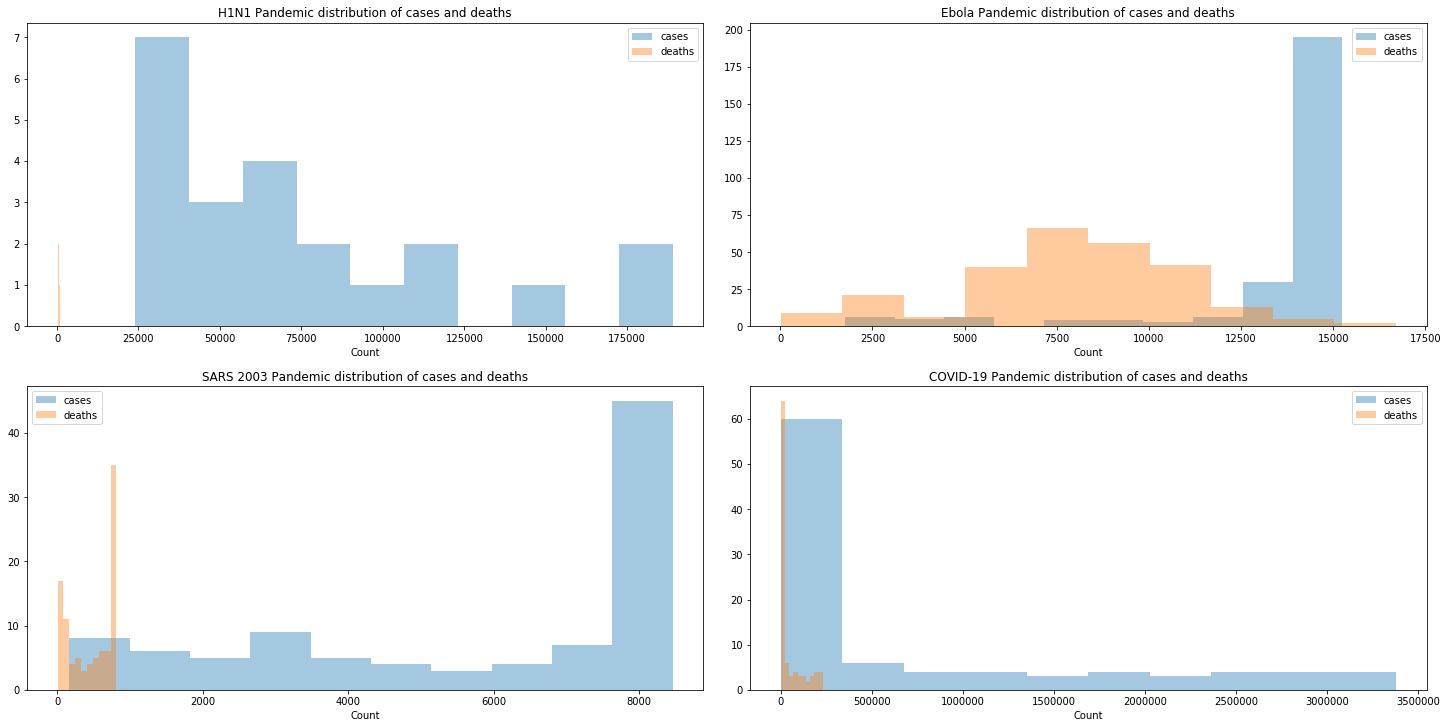

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(20, 10), constrained_layout=True)
axs[0,0].set_title('H1N1 Pandemic distribution of cases and deaths') 
sns.distplot(casesperday['Count'], label = 'cases', kde=False, rug=False, hist=True, bins = 10, ax = axs[0,0])
sns.distplot(deathsperday['Count'], label = 'deaths', kde=False, rug=False, hist=True, bins = 10, ax = axs[0,0])
axs[0,0].legend()
axs[0,1].set_title('Ebola Pandemic distribution of cases and deaths') 
sns.distplot(casesperday_ebola['Count'], label = 'cases', kde=False, rug=False, hist=True, bins = 10, ax=axs[0,1])
sns.distplot(deathsperday_ebola['Count'], label = 'deaths', kde=False, rug=False, hist=True, bins = 10, ax=axs[0,1])
axs[0,1].legend()
axs[1,0].set_title('SARS 2003 Pandemic distribution of cases and deaths') 
sns.distplot(casesperday_sars['Count'], label = 'cases', kde=False, rug=False, hist=True, bins = 10, ax=axs[1,0])
sns.distplot(deathsperday_sars['Count'], label = 'deaths', kde=False, rug=False, hist=True, bins = 10, ax=axs[1,0])
axs[1,0].legend()
axs[1,1].set_title('COVID-19 Pandemic distribution of cases and deaths') 
sns.distplot(casesperday_corona['Count'], label = 'cases', kde=False, rug=False, hist=True, bins = 10, ax=axs[1,1])
sns.distplot(deathsperday_corona['Count'], label = 'deaths', kde=False, rug=False, hist=True, bins = 10, ax=axs[1,1])
axs[1,1].legend()
plt.show()

#### Cases and Deaths for each pandemic

In [36]:
# create new dataframe with date, cases and deaths
df_h1n1 = pd.DataFrame(index = None)
df_h1n1['Date'] = casesperday['Date']
df_h1n1['Cases'] = casesperday['Count']
df_h1n1['Deaths'] = deathsperday['Count']

# convert to string 
for i, row in df_h1n1['Date'].iteritems():
    date  = row.strftime("%d-%m-%Y")
    df_h1n1['Date'].loc[i] = date
    
df_h1n1

C:\Users\AmaliaVogiatzi\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Date,Cases,Deaths
0,23-05-2009,24043,172.0
1,25-05-2009,25029,182.0
2,26-05-2009,25904,184.0
3,27-05-2009,26792,190.0
4,29-05-2009,31011,198.0
5,01-06-2009,34808,230.0
6,03-06-2009,38532,234.0
7,05-06-2009,43864,250.0
8,08-06-2009,50560,278.0
9,10-06-2009,55450,282.0


In [37]:
output_file("h1n1_cases_deaths.html")

data = df_h1n1.to_dict(orient='list')
source = ColumnDataSource(data = data)

idx = df_h1n1['Date'].tolist()


p = figure(x_range=idx, y_range=(0, df_h1n1[['Cases','Deaths']].values.max() + 2), 
           plot_height=500, plot_width=1500, title="H1N1 pandemic cases and deaths",
           toolbar_location='right')

p.line(df_h1n1['Date'], df_h1n1['Cases'], line_width=2, color="#718dbf", alpha=0.8, muted_alpha=0.2, legend='Cases')
p.line(df_h1n1['Date'], df_h1n1['Deaths'], line_width=2, color="#e84d60", alpha=0.8, muted_alpha=0.2, legend='Deaths')

p.legend.location = "top_left"
p.legend.click_policy="mute"
p.x_range.range_padding = 0.2
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2

show(p)

In [38]:
# create new dataframe with date, cases and deaths
df_ebola = pd.DataFrame(index = None)
df_ebola['Date'] = casesperday_ebola['Date']
df_ebola['Cases'] = casesperday_ebola['Count']
df_ebola['Deaths'] = deathsperday_ebola['Count']

for i, row in df_ebola['Date'].iteritems():
    date  = row.strftime("%d-%m-%Y")
    df_ebola['Date'].loc[i] = date
    
df_ebola

,Date,Cases,Deaths
0,29-08-2014,1754.0,898.0
1,05-09-2014,2383.0,1243.0
2,08-09-2014,2552.0,1376.0
3,12-09-2014,2639.0,1386.0
4,16-09-2014,3017.0,1513.0
...,...,...,...
254,17-12-2015,15249.0,12108.0
255,22-12-2015,15249.0,11589.0
256,23-12-2015,15249.0,10082.0
257,29-12-2015,15249.0,8521.5


In [39]:
output_file("ebola_cases_deaths.html")

data = df_ebola.to_dict(orient='list')
source = ColumnDataSource(data = data)

idx = df_ebola['Date'].tolist()


p = figure(x_range=idx, y_range=(0, df_ebola[['Cases','Deaths']].values.max() + 2), 
           plot_height=500, plot_width=3000, title="Ebola pandemic cases and deaths",
           toolbar_location='right')

p.line(df_ebola['Date'], df_ebola['Cases'], line_width=2, color="#718dbf", alpha=0.8, muted_alpha=0.2, legend='Cases')
p.line(df_ebola['Date'], df_ebola['Deaths'], line_width=2, color="#e84d60", alpha=0.8, muted_alpha=0.2, legend='Deaths')

p.legend.location = "top_left"
p.legend.click_policy="mute"
p.x_range.range_padding = 0
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2

show(p)

In [40]:
# create new dataframe with date, cases and deaths
df_sars = pd.DataFrame(index = None)
df_sars['Date'] = casesperday_sars['Date']
df_sars['Cases'] = casesperday_sars['Count']
df_sars['Deaths'] = deathsperday_sars['Count']

# convert to string 
for i, row in df_sars['Date'].iteritems():
    date  = row.strftime("%d-%m-%Y")
    df_sars['Date'].loc[i] = date
    
df_sars

,Date,Cases,Deaths
0,17-03-2003,167,4
1,18-03-2003,219,4
2,19-03-2003,264,9
3,20-03-2003,306,10
4,21-03-2003,350,10
...,...,...,...
91,07-07-2003,8434,812
92,08-07-2003,8431,812
93,09-07-2003,8431,812
94,10-07-2003,8432,812


In [41]:
output_file("sars_cases_deaths.html")

data = df_sars.to_dict(orient='list')
source = ColumnDataSource(data = data)

idx = df_sars['Date'].tolist()


p = figure(x_range=idx, y_range=(0, df_sars[['Cases','Deaths']].values.max() + 2), 
           plot_height=500, plot_width=2000, title="SARS 2003 pandemic cases and deaths",
           toolbar_location='right')

p.line(df_sars['Date'], df_sars['Cases'], line_width=2, color="#718dbf", alpha=0.8, muted_alpha=0.2, legend='Cases')
p.line(df_sars['Date'], df_sars['Deaths'], line_width=2, color="#e84d60", alpha=0.8, muted_alpha=0.2, legend='Deaths')

p.legend.location = "top_left"
p.legend.click_policy="mute"
p.x_range.range_padding = 0
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2

show(p)

In [42]:
# create new dataframe with date, cases and deaths
df_corona = pd.DataFrame(index = None)
df_corona['Date'] = casesperday_corona['Date']
df_corona['Cases'] = casesperday_corona['Count']
df_corona['Deaths'] = deathsperday_corona['Count']

# convert to string 
for i, row in df_corona['Date'].iteritems():
    date  = row.strftime("%d-%m-%Y")
    df_corona['Date'].loc[i] = date
    
df_corona

,Date,Cases,Deaths
0,22-01-2020,777.0,25.5
1,23-01-2020,928.5,30.0
2,24-01-2020,1321.5,46.0
3,25-01-2020,1963.0,68.0
4,26-01-2020,2829.5,94.0
...,...,...,...
91,22-04-2020,3056921.5,208027.5
92,23-04-2020,3159694.5,216818.0
93,24-04-2020,3277863.5,223868.0
94,25-04-2020,3378924.0,230271.0


In [43]:
output_file("corona_cases_deaths.html")

data = df_corona.to_dict(orient='list')
source = ColumnDataSource(data = data)

idx = df_corona['Date'].tolist()


p = figure(x_range=idx, y_range=(0, df_corona[['Cases','Deaths']].values.max() + 2), 
           plot_height=500, plot_width=2500, title="COVID-19 pandemic cases and deaths",
           toolbar_location='right')

p.line(df_corona['Date'], df_corona['Cases'], line_width=2, color="#718dbf", alpha=0.8, muted_alpha=0.2, legend='Cases')
p.line(df_corona['Date'], df_corona['Deaths'], line_width=2, color="#e84d60", alpha=0.8, muted_alpha=0.2, legend='Deaths')

p.legend.location = "top_left"
p.legend.click_policy="mute"
p.x_range.range_padding = 0
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2

show(p)

#### Time Series Analysis of Cases in top 10 countries for each pandemic

In [44]:
# find H1N1 cases and deaths per country and date
top10 = h1n1.groupby(['Country']).Cases.sum()
top10 = top10.sort_values(ascending=False)
top10 = top10[:12].index.tolist()
top10.remove('Grand Total')
top10.remove('United States of America*')
filtered_h1n1 = h1n1[h1n1['Country'].isin(top10)]
filtered_h1n1

,Country,Cases,Deaths,UpdateTime,Date
2,Argentina,2485,60.0,7/6/2009 9:00,2009-07-06
3,Australia,5298,10.0,7/6/2009 9:00,2009-07-06
18,Canada,7983,25.0,7/6/2009 9:00,2009-07-06
21,Chile,7376,14.0,7/6/2009 9:00,2009-07-06
22,China,2040,0.0,7/6/2009 9:00,2009-07-06
...,...,...,...,...,...
1801,Japan,321,0.0,5/23/2009 8:00,2009-05-23
1804,Mexico,3892,75.0,5/23/2009 8:00,2009-05-23
1817,Thailand,2,0.0,5/23/2009 8:00,2009-05-23
1819,United Kingdom,117,0.0,5/23/2009 8:00,2009-05-23


In [45]:
casesperday_country = filtered_h1n1.groupby(['Country', 'Date']).Cases.sum()
casesperday_country = casesperday_country.unstack(level = 0)
casesperday_country = casesperday_country.fillna(0)
casesperday_country.reset_index(inplace=True)
casesperday_country

Country,Date,Argentina,Australia,Canada,Chile,China,Japan,Mexico,Thailand,United Kingdom,United States of America
0,2009-05-23,1.0,12.0,719.0,24.0,11.0,321.0,3892.0,2.0,117.0,6552.0
1,2009-05-25,2.0,16.0,805.0,44.0,15.0,345.0,4174.0,2.0,122.0,6552.0
2,2009-05-26,5.0,19.0,921.0,74.0,20.0,350.0,4174.0,2.0,137.0,6764.0
3,2009-05-27,19.0,39.0,921.0,86.0,22.0,360.0,4541.0,2.0,137.0,6764.0
4,2009-05-29,37.0,147.0,1118.0,165.0,30.0,364.0,4910.0,2.0,203.0,7927.0
5,2009-06-01,100.0,297.0,1336.0,250.0,52.0,370.0,5029.0,2.0,229.0,8975.0
6,2009-06-03,131.0,501.0,1530.0,313.0,69.0,385.0,5029.0,2.0,339.0,10053.0
7,2009-06-05,147.0,876.0,1795.0,369.0,89.0,410.0,5563.0,8.0,428.0,11054.0
8,2009-06-08,202.0,1051.0,2115.0,411.0,108.0,410.0,5717.0,8.0,557.0,13217.0
9,2009-06-10,235.0,1224.0,2446.0,1694.0,142.0,485.0,5717.0,8.0,666.0,13217.0


In [46]:
countries = set(filtered_h1n1.Country.unique())
dates = []
for i in casesperday_country['Date']:
    dates.append(i.strftime("%d-%m-%Y"))
    
mycolors = []
for i in range(len(countries)):
    color = "%06x" % random.randint(0, 0xFFFFFF)
    mycolors.append(color)

In [47]:
output_file("h1n1_cases_top10.html")

src = ColumnDataSource(casesperday_country)

p = figure(y_range=(0, casesperday_country.drop(['Date'], axis=1).values.max()), x_axis_type='datetime',
           x_axis_label='Date', y_axis_label='Number of cases',
           plot_height=500, plot_width=1500, title="H1N1 cases per country",
           toolbar_location='right')

line = {}
myitems = []
for i, c in enumerate(countries):
    line[c] = p.line(casesperday_country['Date'], casesperday_country[c], line_width=2, color="#" + mycolors[i], alpha=0.8, muted_alpha=0, legend=c)
    myitems.append((c, [line[c]]))
    
p.legend.visible = False
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2
p.legend.location = "top_left"
p.legend.click_policy="mute"
legend = Legend(items = myitems, location='top_left', click_policy="mute")
legend.title = 'Add countries'
p.add_layout(legend, 'right')
show(p)

In [48]:
# find ebola cases and deaths per country and date
top10_ebola = ebola.groupby(['Country']).Cases.sum()
top10_ebola = top10_ebola.sort_values(ascending=False)
top10_ebola = top10_ebola[:10].index.tolist()
filtered_ebola = ebola[ebola['Country'].isin(top10_ebola)]
filtered_ebola

,Country,Date,No. of suspected cases,No. of probable cases,Cases,"No. of confirmed, probable and suspected cases",No. of suspected deaths,No. of probable deaths,Deaths,"No. of confirmed, probable and suspected deaths"
0,Guinea,2014-08-29,25.0,141.0,482.0,648.0,2.0,141.0,287.000000,430.0
1,Nigeria,2014-08-29,3.0,1.0,15.0,19.0,0.0,1.0,6.000000,7.0
2,Sierra Leone,2014-08-29,54.0,37.0,935.0,1026.0,8.0,34.0,380.000000,422.0
3,Liberia,2014-08-29,382.0,674.0,322.0,1378.0,168.0,301.0,225.000000,694.0
4,Sierra Leone,2014-09-05,78.0,37.0,1146.0,1261.0,11.0,37.0,443.000000,491.0
...,...,...,...,...,...,...,...,...,...,...
2480,Liberia,2016-03-23,5636.0,1879.0,3151.0,10666.0,NaN,NaN,2.333333,4806.0
2481,Italy,2016-03-23,0.0,0.0,1.0,1.0,NaN,NaN,1.666667,0.0
2482,Liberia,2016-03-23,0.0,3.0,2.0,5.0,NaN,3.0,1.000000,4.0
2483,Nigeria,2016-03-23,0.0,1.0,19.0,20.0,0.0,1.0,7.000000,8.0


In [49]:
casesperday_country_ebola = filtered_ebola.groupby(['Country', 'Date']).Cases.sum()
casesperday_country_ebola = casesperday_country_ebola.unstack(level = 0)
casesperday_country_ebola = casesperday_country_ebola.fillna(0)
casesperday_country_ebola.reset_index(inplace=True)
casesperday_country_ebola

Country,Date,Guinea,Italy,Liberia,Mali,Nigeria,Senegal,Sierra Leone,Spain,United Kingdom,United States of America
0,2014-08-29,482.0,0.0,322.0,0.0,15.0,0.0,935.0,0.0,0.0,0.0
1,2014-09-05,604.0,0.0,614.0,0.0,18.0,1.0,1146.0,0.0,0.0,0.0
2,2014-09-08,664.0,0.0,634.0,0.0,19.0,1.0,1234.0,0.0,0.0,0.0
3,2014-09-12,678.0,0.0,654.0,0.0,19.0,1.0,1287.0,0.0,0.0,0.0
4,2014-09-16,743.0,0.0,790.0,0.0,19.0,1.0,1464.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
254,2015-12-17,3351.0,1.0,3160.0,7.0,19.0,1.0,8704.0,1.0,1.0,4.0
255,2015-12-22,3351.0,1.0,3160.0,7.0,19.0,1.0,8704.0,1.0,1.0,4.0
256,2015-12-23,3351.0,1.0,3160.0,7.0,19.0,1.0,8704.0,1.0,1.0,4.0
257,2015-12-29,3351.0,1.0,3160.0,7.0,19.0,1.0,8704.0,1.0,1.0,4.0


In [50]:
countries_ebola = set(filtered_ebola.Country.unique())
dates = []
for i in casesperday_country_ebola['Date']:
    dates.append(i.strftime("%d-%m-%Y"))
    
mycolors = []
for i in range(len(countries_ebola)):
    color = "%06x" % random.randint(0, 0xFFFFFF)
    mycolors.append(color)

In [51]:
output_file("ebola_cases_top10.html")

src = ColumnDataSource(casesperday_country_ebola)

p = figure(y_range=(0, casesperday_country_ebola.drop(['Date'], axis=1).values.max()), x_axis_type='datetime',
           x_axis_label='Date', y_axis_label='Number of cases',
           plot_height=500, plot_width=1500, title="Ebola cases per country",
           toolbar_location='right')

line = {}
myitems = []
for i, c in enumerate(countries_ebola):
    line[c] = p.line(casesperday_country_ebola['Date'], casesperday_country_ebola[c], line_width=2, color="#" + mycolors[i], alpha=0.8, muted_alpha=0, legend=c)
    myitems.append((c, [line[c]]))
    
p.legend.visible = False
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2
p.legend.location = "top_left"
p.legend.click_policy="mute"
legend = Legend(items = myitems, location='top_left', click_policy="mute")
legend.title = 'Add countries'
p.add_layout(legend, 'right')
show(p)

In [52]:
# find sars cases and deaths per country and date
top10_sars = sars.groupby(['Country']).Cases.sum()
top10_sars = top10_sars.sort_values(ascending=False)
top10_sars = top10_sars[:10].index.tolist()
filtered_sars = sars[sars['Country'].isin(top10_sars)]
filtered_sars

,Date,Country,Cases,Deaths,Recovered
0,2003-03-17,Germany,1,0,0
1,2003-03-17,Canada,8,2,0
2,2003-03-17,Singapore,20,0,0
3,2003-03-17,"Hong Kong SAR, China",95,1,0
5,2003-03-17,Thailand,1,0,0
...,...,...,...,...,...
2524,2003-07-11,Philippines,14,2,12
2529,2003-07-11,Singapore,206,32,172
2534,2003-07-11,Thailand,9,2,7
2536,2003-07-11,United States,75,0,67


In [53]:
casesperday_country_sars = filtered_sars.groupby(['Country', 'Date']).Cases.sum()
casesperday_country_sars = casesperday_country_sars.unstack(level = 0)
casesperday_country_sars = casesperday_country_sars.fillna(0)
casesperday_country_sars.reset_index(inplace=True)
casesperday_country_sars

Country,Date,Canada,China,Germany,"Hong Kong SAR, China",Philippines,Singapore,"Taiwan, China",Thailand,United States,Viet Nam
0,2003-03-17,8.0,0.0,1.0,95.0,0.0,20.0,0.0,1.0,0.0,40.0
1,2003-03-18,8.0,0.0,2.0,123.0,0.0,23.0,3.0,1.0,0.0,57.0
2,2003-03-19,8.0,0.0,1.0,150.0,0.0,31.0,3.0,1.0,11.0,56.0
3,2003-03-20,9.0,0.0,1.0,173.0,0.0,34.0,4.0,1.0,11.0,62.0
4,2003-03-21,9.0,0.0,1.0,203.0,0.0,39.0,6.0,4.0,13.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...
91,2003-07-07,251.0,5327.0,10.0,1755.0,14.0,206.0,674.0,9.0,73.0,63.0
92,2003-07-08,250.0,5327.0,10.0,1755.0,14.0,206.0,671.0,9.0,74.0,63.0
93,2003-07-09,249.0,5327.0,10.0,1755.0,14.0,206.0,671.0,9.0,75.0,63.0
94,2003-07-10,250.0,5327.0,10.0,1755.0,14.0,206.0,671.0,9.0,75.0,63.0


In [54]:
countries_sars = set(filtered_sars.Country.unique())
dates = []
for i in casesperday_country_sars['Date']:
    dates.append(i.strftime("%d-%m-%Y"))
    
mycolors = []
for i in range(len(countries_sars)):
    color = "%06x" % random.randint(0, 0xFFFFFF)
    mycolors.append(color)

In [55]:
output_file("sars_cases_top10.html")

src = ColumnDataSource(casesperday_country_sars)

p = figure(y_range=(0, casesperday_country_sars.drop(['Date'], axis=1).values.max()), x_axis_type='datetime',
           x_axis_label='Date', y_axis_label='Number of cases',
           plot_height=500, plot_width=1500, title="SARS 2003 cases per country",
           toolbar_location='right')

line = {}
myitems = []
for i, c in enumerate(countries_sars):
    line[c] = p.line(casesperday_country_sars['Date'], casesperday_country_sars[c], line_width=2, color="#" + mycolors[i], alpha=0.8, muted_alpha=0, legend=c)
    myitems.append((c, [line[c]]))
    
p.legend.visible = False
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2
p.legend.location = "top_left"
p.legend.click_policy="mute"
legend = Legend(items = myitems, location='top_left', click_policy="mute")
legend.title = 'Add countries'
p.add_layout(legend, 'right')
show(p)

In [56]:
# find corona cases and deaths per country and date
top10_corona = corona.groupby(['Country']).Cases.sum()
top10_corona = top10_corona.sort_values(ascending=False)
top10_corona = top10_corona[:10].index.tolist()
filtered_corona = corona[corona['Country'].isin(top10_corona)]
filtered_corona

,Country,Province_State,Date,Latitude,Longitude,Cases,Deaths,Recovered
0,China,Hubei,2020-01-22,30.9756,112.2707,444.0,17.0,28
1,China,Guangdong,2020-01-22,23.3417,113.4244,26.0,0.0,0
2,China,Beijing,2020-01-22,40.1824,116.4142,14.0,0.0,0
3,China,Zhejiang,2020-01-22,29.1832,120.0934,10.0,0.0,0
4,China,Shanghai,2020-01-22,31.2020,121.4491,9.0,0.0,0
...,...,...,...,...,...,...,...,...
25339,Canada,Diamond Princess,2020-04-26,0.0000,0.0000,0.0,1.0,645
25340,Canada,Recovered,2020-04-26,0.0000,0.0000,0.0,0.0,0
25341,Canada,Grand Princess,2020-04-26,37.6489,-122.6655,-1.0,-1.0,0
25342,Canada,Nova Scotia,2020-04-26,44.6820,-63.7443,-1.0,-1.0,0


In [57]:
casesperday_country_corona = filtered_corona.groupby(['Country', 'Date']).Cases.sum()
casesperday_country_corona = casesperday_country_corona.unstack(level = 0)
casesperday_country_corona = casesperday_country_corona.fillna(0)
casesperday_country_corona.reset_index(inplace=True)
casesperday_country_corona

Country,Date,Canada,China,France,Germany,Iran,Italy,Spain,Turkey,US,United Kingdom
0,2020-01-22,222.0,548.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2020-01-23,274.5,643.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2020-01-24,380.5,920.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,2020-01-25,529.0,1406.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,2020-01-26,712.5,2075.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
91,2020-04-22,476232.5,83868.0,155980.0,150648.0,85996.0,187327.0,208389.0,98674.0,840351.0,134638.0
92,2020-04-23,495963.5,83884.0,158303.0,153129.0,87026.0,189973.0,213024.0,101790.0,869170.0,139246.0
93,2020-04-24,513130.5,83899.0,159952.0,154999.0,88194.0,192994.0,219764.0,104912.0,905358.0,144640.0
94,2020-04-25,528383.0,83909.0,161644.0,156513.0,89328.0,195351.0,223759.0,107773.0,938154.0,149569.0


In [58]:
countries_corona = set(filtered_corona.Country.unique())
dates = []
for i in casesperday_country_corona['Date']:
    dates.append(i.strftime("%d-%m-%Y"))
    
mycolors = []
for i in range(len(countries_corona)):
    color = "%06x" % random.randint(0, 0xFFFFFF)
    mycolors.append(color)

In [59]:
output_file("corona_cases_top10.html")

src = ColumnDataSource(casesperday_country_corona)

p = figure(y_range=(0, casesperday_country_corona.drop(['Date'], axis=1).values.max()), x_axis_type='datetime',
           x_axis_label='Date', y_axis_label='Number of cases',
           plot_height=500, plot_width=1500, title="COVID-19 cases per country",
           toolbar_location='right')

line = {}
myitems = []
for i, c in enumerate(countries_corona):
    line[c] = p.line(casesperday_country_corona['Date'], casesperday_country_corona[c], line_width=2, color="#" + mycolors[i], alpha=0.8, muted_alpha=0, legend=c)
    myitems.append((c, [line[c]]))
    
p.legend.visible = False
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2
p.legend.location = "top_left"
p.legend.click_policy="mute"
legend = Legend(items = myitems, location='top_left', click_policy="mute")
legend.title = 'Add countries'
p.add_layout(legend, 'right')
show(p)

#### Time Series Analysis of Deaths in top 10 countries for each pandemic

In [60]:
deathsperday_country = filtered_h1n1.groupby(['Country', 'Date']).Deaths.sum()
deathsperday_country = deathsperday_country.unstack(level = 0)
deathsperday_country = deathsperday_country.fillna(0)
deathsperday_country.reset_index(inplace=True)
deathsperday_country

Country,Date,Argentina,Australia,Canada,Chile,China,Japan,Mexico,Thailand,United Kingdom,United States of America
0,2009-05-23,0.0,0.0,1.0,0.0,0.0,0.0,75.0,0.0,0.0,9.0
1,2009-05-25,0.0,0.0,1.0,0.0,0.0,0.0,80.0,0.0,0.0,9.0
2,2009-05-26,0.0,0.0,1.0,0.0,0.0,0.0,80.0,0.0,0.0,10.0
3,2009-05-27,0.0,0.0,1.0,0.0,0.0,0.0,83.0,0.0,0.0,10.0
4,2009-05-29,0.0,0.0,2.0,0.0,0.0,0.0,85.0,0.0,0.0,11.0
5,2009-06-01,0.0,0.0,2.0,0.0,0.0,0.0,97.0,0.0,0.0,15.0
6,2009-06-03,0.0,0.0,2.0,0.0,0.0,0.0,97.0,0.0,0.0,17.0
7,2009-06-05,0.0,0.0,3.0,1.0,0.0,0.0,103.0,0.0,0.0,17.0
8,2009-06-08,0.0,0.0,3.0,1.0,0.0,0.0,106.0,0.0,0.0,27.0
9,2009-06-10,0.0,0.0,4.0,2.0,0.0,0.0,106.0,0.0,0.0,27.0


In [61]:
output_file("h1n1_deaths_top10.html")

src = ColumnDataSource(deathsperday_country)

p = figure(y_range=(0, deathsperday_country.drop(['Date'], axis=1).values.max()), x_axis_type='datetime',
           x_axis_label='Date', y_axis_label='Number of deaths',
           plot_height=500, plot_width=1500, title="H1N1 deaths per country",
           toolbar_location='right')

line = {}
myitems = []
for i, c in enumerate(countries):
    line[c] = p.line(deathsperday_country['Date'], deathsperday_country[c], line_width=2, color="#" + mycolors[i], alpha=0.8, muted_alpha=0, legend=c)
    myitems.append((c, [line[c]]))
    
p.legend.visible = False
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2
p.legend.location = "top_left"
p.legend.click_policy="mute"
legend = Legend(items = myitems, location='top_left', click_policy="mute")
legend.title = 'Add countries'
p.add_layout(legend, 'right')
show(p)

In [62]:
deathsperday_country_ebola = filtered_ebola.groupby(['Country', 'Date']).Deaths.sum()
deathsperday_country_ebola = deathsperday_country_ebola.unstack(level = 0)
deathsperday_country_ebola = deathsperday_country_ebola.fillna(0)
deathsperday_country_ebola.reset_index(inplace=True)
deathsperday_country_ebola

Country,Date,Guinea,Italy,Liberia,Mali,Nigeria,Senegal,Sierra Leone,Spain,United Kingdom,United States of America
0,2014-08-29,287.0,0.000000,225.000000,0.0,6.0,0.0,380.0,0.0,0.000000,0.0
1,2014-09-05,362.0,0.000000,431.000000,0.0,7.0,0.0,443.0,0.0,0.000000,0.0
2,2014-09-08,400.0,0.000000,508.000000,0.0,7.0,0.0,461.0,0.0,0.000000,0.0
3,2014-09-12,403.0,0.000000,498.000000,0.0,7.0,0.0,478.0,0.0,0.000000,0.0
4,2014-09-16,429.0,0.000000,563.000000,0.0,7.0,0.0,514.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
254,2015-12-17,2083.0,1041.500000,900.250000,1794.5,7.0,0.0,3589.0,0.0,2691.750000,1.0
255,2015-12-22,2083.0,1197.000000,524.500000,1794.5,7.0,0.0,3589.0,0.0,2393.000000,1.0
256,2015-12-23,2083.0,1562.500000,3.000000,1794.5,7.0,0.0,3589.0,0.0,1042.000000,1.0
257,2015-12-29,2083.0,0.333333,4.500000,2836.0,7.0,0.0,3589.0,0.0,0.666667,1.0


In [63]:
output_file("ebola_deaths_top10.html")

src = ColumnDataSource(deathsperday_country_ebola)

p = figure(y_range=(0, deathsperday_country_ebola.drop(['Date'], axis=1).values.max()), x_axis_type='datetime',
           x_axis_label='Date', y_axis_label='Number of deaths',
           plot_height=500, plot_width=1500, title="Ebola deaths per country",
           toolbar_location='right')

line = {}
myitems = []
for i, c in enumerate(countries_ebola):
    line[c] = p.line(deathsperday_country_ebola['Date'], deathsperday_country_ebola[c], line_width=2, color="#" + mycolors[i], alpha=0.8, muted_alpha=0, legend=c)
    myitems.append((c, [line[c]]))
    
p.legend.visible = False
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2
p.legend.location = "top_left"
p.legend.click_policy="mute"
legend = Legend(items = myitems, location='top_left', click_policy="mute")
legend.title = 'Add countries'
p.add_layout(legend, 'right')
show(p)

In [64]:
deathsperday_country_sars = filtered_sars.groupby(['Country', 'Date']).Deaths.sum()
deathsperday_country_sars = deathsperday_country_sars.unstack(level = 0)
deathsperday_country_sars = deathsperday_country_sars.fillna(0)
deathsperday_country_sars.reset_index(inplace=True)
deathsperday_country_sars

Country,Date,Canada,China,Germany,"Hong Kong SAR, China",Philippines,Singapore,"Taiwan, China",Thailand,United States,Viet Nam
0,2003-03-17,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2003-03-18,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2003-03-19,2.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0
3,2003-03-20,2.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0
4,2003-03-21,2.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
91,2003-07-07,38.0,348.0,0.0,298.0,2.0,32.0,84.0,2.0,0.0,5.0
92,2003-07-08,38.0,348.0,0.0,298.0,2.0,32.0,84.0,2.0,0.0,5.0
93,2003-07-09,38.0,348.0,0.0,298.0,2.0,32.0,84.0,2.0,0.0,5.0
94,2003-07-10,38.0,348.0,0.0,298.0,2.0,32.0,84.0,2.0,0.0,5.0


In [65]:
output_file("sars_deaths_top10.html")

src = ColumnDataSource(deathsperday_country_sars)

p = figure(y_range=(0, deathsperday_country_sars.drop(['Date'], axis=1).values.max()), x_axis_type='datetime',
           x_axis_label='Date', y_axis_label='Number of deaths',
           plot_height=500, plot_width=1500, title="SARS 2003 deaths per country",
           toolbar_location='right')

line = {}
myitems = []
for i, c in enumerate(countries_sars):
    line[c] = p.line(deathsperday_country_sars['Date'], deathsperday_country_sars[c], line_width=2, color="#" + mycolors[i], alpha=0.8, muted_alpha=0, legend=c)
    myitems.append((c, [line[c]]))
    
p.legend.visible = False
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2
p.legend.location = "top_left"
p.legend.click_policy="mute"
legend = Legend(items = myitems, location='top_left', click_policy="mute")
legend.title = 'Add countries'
p.add_layout(legend, 'right')
show(p)


In [66]:
deathsperday_country_corona = filtered_corona.groupby(['Country', 'Date']).Deaths.sum()
deathsperday_country_corona = deathsperday_country_corona.unstack(level = 0)
deathsperday_country_corona = deathsperday_country_corona.fillna(0)
deathsperday_country_corona.reset_index(inplace=True)
deathsperday_country_corona

Country,Date,Canada,China,France,Germany,Iran,Italy,Spain,Turkey,US,United Kingdom
0,2020-01-22,8.5,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,12.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,20.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,26.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-26,38.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
91,2020-04-22,27051.5,4636.0,21373.0,5279.0,5391.0,25085.0,21717.0,2376.0,46622.0,18151.0
92,2020-04-23,28214.0,4636.0,21889.0,5575.0,5481.0,25549.0,22157.0,2491.0,49954.0,18791.0
93,2020-04-24,29261.0,4636.0,22279.0,5760.0,5574.0,25969.0,22524.0,2600.0,51949.0,19567.0
94,2020-04-25,29987.0,4636.0,22648.0,5877.0,5650.0,26384.0,22902.0,2706.0,53755.0,20381.0


In [67]:
output_file("corona_deaths_top10.html")

src = ColumnDataSource(deathsperday_country_corona)

p = figure(y_range=(0, deathsperday_country_corona.drop(['Date'], axis=1).values.max()), x_axis_type='datetime',
           x_axis_label='Date', y_axis_label='Number of deaths',
           plot_height=500, plot_width=1500, title="COVID-19 deaths per country",
           toolbar_location='right')

line = {}
myitems = []
for i, c in enumerate(countries_corona):
    line[c] = p.line(deathsperday_country_corona['Date'], deathsperday_country_corona[c], line_width=2, color="#" + mycolors[i], alpha=0.8, muted_alpha=0, legend=c)
    myitems.append((c, [line[c]]))
    
p.legend.visible = False
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2
p.legend.location = "top_left"
p.legend.click_policy="mute"
legend = Legend(items = myitems, location='top_left', click_policy="mute")
legend.title = 'Add countries'
p.add_layout(legend, 'right')
show(p)


#### Time Series Analysis of Deaths in top 20 countries for Coronavirus

In [68]:
# find corona cases and deaths per country and date
top20_corona = corona.groupby(['Country']).Cases.sum()
top20_corona = top20_corona.sort_values(ascending=False)
top20_corona = top20_corona[:20].index.tolist()
filtered_corona2 = corona[corona['Country'].isin(top20_corona)]
filtered_corona2

,Country,Province_State,Date,Latitude,Longitude,Cases,Deaths,Recovered
0,China,Hubei,2020-01-22,30.9756,112.2707,444.0,17.0,28
1,China,Guangdong,2020-01-22,23.3417,113.4244,26.0,0.0,0
2,China,Beijing,2020-01-22,40.1824,116.4142,14.0,0.0,0
3,China,Zhejiang,2020-01-22,29.1832,120.0934,10.0,0.0,0
4,China,Shanghai,2020-01-22,31.2020,121.4491,9.0,0.0,0
...,...,...,...,...,...,...,...,...
25339,Canada,Diamond Princess,2020-04-26,0.0000,0.0000,0.0,1.0,645
25340,Canada,Recovered,2020-04-26,0.0000,0.0000,0.0,0.0,0
25341,Canada,Grand Princess,2020-04-26,37.6489,-122.6655,-1.0,-1.0,0
25342,Canada,Nova Scotia,2020-04-26,44.6820,-63.7443,-1.0,-1.0,0


In [69]:
casesperday_country_corona2 = filtered_corona2.groupby(['Country', 'Date']).Cases.sum()
casesperday_country_corona2 = casesperday_country_corona2.unstack(level = 0)
casesperday_country_corona2 = casesperday_country_corona2.fillna(0)
casesperday_country_corona2.reset_index(inplace=True)
casesperday_country_corona2

Country,Date,Austria,Belgium,Brazil,Canada,China,France,Germany,Iran,Israel,...,"Korea, South",Netherlands,Portugal,Russia,Spain,Sweden,Switzerland,Turkey,US,United Kingdom
0,2020-01-22,0.0,0.0,0.0,222.0,548.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2020-01-23,0.0,0.0,0.0,274.5,643.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2020-01-24,0.0,0.0,0.0,380.5,920.0,2.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,2020-01-25,0.0,0.0,0.0,529.0,1406.0,3.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,2020-01-26,0.0,0.0,0.0,712.5,2075.0,3.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2020-04-22,14925.0,41889.0,45757.0,476232.5,83868.0,155980.0,150648.0,85996.0,14498.0,...,10694.0,35032.0,21982.0,57999.0,208389.0,16004.0,28268.0,98674.0,840351.0,134638.0
92,2020-04-23,15002.0,42797.0,50036.0,495963.5,83884.0,158303.0,153129.0,87026.0,14803.0,...,10708.0,35921.0,22353.0,62773.0,213024.0,16755.0,28496.0,101790.0,869170.0,139246.0
93,2020-04-24,15071.0,44293.0,54043.0,513130.5,83899.0,159952.0,154999.0,88194.0,15058.0,...,10718.0,36729.0,22797.0,68622.0,219764.0,17567.0,28677.0,104912.0,905358.0,144640.0
94,2020-04-25,15148.0,45325.0,59324.0,528383.0,83909.0,161644.0,156513.0,89328.0,15298.0,...,10728.0,37384.0,23392.0,74588.0,223759.0,18177.0,28894.0,107773.0,938154.0,149569.0


In [70]:
countries_corona2 = set(filtered_corona2.Country.unique())
dates2 = []
for i in casesperday_country_corona2['Date']:
    dates2.append(i.strftime("%d-%m-%Y"))
    
mycolors = []
for i in range(len(countries_corona2)):
    color = "%06x" % random.randint(0, 0xFFFFFF)
    mycolors.append(color)

In [71]:
output_file("corona_cases_top20.html")

src = ColumnDataSource(casesperday_country_corona2)

p = figure(y_range=(0, casesperday_country_corona2.drop(['Date'], axis=1).values.max()), x_axis_type='datetime',
           x_axis_label='Date', y_axis_label='Number of cases',
           plot_height=600, plot_width=1500, title="COVID-19 cases per country",
           toolbar_location='right')

line = {}
myitems = []
for i, c in enumerate(countries_corona2):
    line[c] = p.line(casesperday_country_corona2['Date'], casesperday_country_corona2[c], line_width=2, color="#" + mycolors[i], alpha=0.8, muted_alpha=0, legend=c)
    myitems.append((c, [line[c]]))
    
p.legend.visible = False
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2
p.legend.location = "top_left"
p.legend.click_policy="mute"
legend = Legend(items = myitems, location='top_left', click_policy="mute")
legend.title = 'Add countries'
p.add_layout(legend, 'right')
show(p)

In [72]:
deathsperday_country_corona2 = filtered_corona2.groupby(['Country', 'Date']).Deaths.sum()
deathsperday_country_corona2 = deathsperday_country_corona2.unstack(level = 0)
deathsperday_country_corona2 = deathsperday_country_corona2.fillna(0)
deathsperday_country_corona2.reset_index(inplace=True)
deathsperday_country_corona2

Country,Date,Austria,Belgium,Brazil,Canada,China,France,Germany,Iran,Israel,...,"Korea, South",Netherlands,Portugal,Russia,Spain,Sweden,Switzerland,Turkey,US,United Kingdom
0,2020-01-22,0.0,0.0,0.0,8.5,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0,12.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,0.0,0.0,0.0,20.0,26.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0,26.0,42.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-26,0.0,0.0,0.0,38.0,56.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2020-04-22,510.0,6262.0,2906.0,27051.5,4636.0,21373.0,5279.0,5391.0,189.0,...,238.0,4068.0,785.0,513.0,21717.0,1937.0,1509.0,2376.0,46622.0,18151.0
92,2020-04-23,522.0,6490.0,3331.0,28214.0,4636.0,21889.0,5575.0,5481.0,192.0,...,240.0,4192.0,820.0,555.0,22157.0,2021.0,1549.0,2491.0,49954.0,18791.0
93,2020-04-24,530.0,6679.0,3704.0,29261.0,4636.0,22279.0,5760.0,5574.0,194.0,...,240.0,4304.0,854.0,615.0,22524.0,2152.0,1589.0,2600.0,51949.0,19567.0
94,2020-04-25,536.0,6917.0,4057.0,29987.0,4636.0,22648.0,5877.0,5650.0,199.0,...,242.0,4424.0,880.0,681.0,22902.0,2192.0,1599.0,2706.0,53755.0,20381.0


In [73]:
output_file("corona_deaths_top20.html")

src = ColumnDataSource(deathsperday_country_corona2)

p = figure(y_range=(0, deathsperday_country_corona2.drop(['Date'], axis=1).values.max()), x_axis_type='datetime',
           x_axis_label='Date', y_axis_label='Number of deaths',
           plot_height=600, plot_width=1500, title="COVID-19 deaths per country",
           toolbar_location='right')

line = {}
myitems = []
for i, c in enumerate(countries_corona2):
    line[c] = p.line(deathsperday_country_corona2['Date'], deathsperday_country_corona2[c], line_width=2, color="#" + mycolors[i], alpha=0.8, muted_alpha=0, legend=c)
    myitems.append((c, [line[c]]))
    
p.legend.visible = False
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2
p.legend.location = "top_left"
p.legend.click_policy="mute"
legend = Legend(items = myitems, location='top_left', click_policy="mute")
legend.title = 'Add countries'
p.add_layout(legend, 'right')
show(p)


#### Time Series Analysis of Cases and Deaths in Nordic Countries for Coronavirus

In [74]:
nordic = ['Iceland', 'Denmark', 'Sweden', 'Norway', 'Finland']
filtered_corona3 = corona[corona['Country'].isin(nordic)]
filtered_corona3

,Country,Province_State,Date,Latitude,Longitude,Cases,Deaths,Recovered
97,Denmark,Faroe Islands,2020-01-22,61.8926,-6.9118,0.0,0.0,0
98,Denmark,Greenland,2020-01-22,71.7069,-42.6043,0.0,0.0,0
99,Denmark,,2020-01-22,56.2639,9.5018,0.0,0.0,0
111,Finland,,2020-01-22,64.0000,26.0000,0.0,0.0,0
135,Iceland,,2020-01-22,64.9631,-19.0208,0.0,0.0,0
...,...,...,...,...,...,...,...,...
25120,Norway,,2020-04-26,60.4720,8.4689,7527.0,201.0,32
25128,Finland,,2020-04-26,64.0000,26.0000,4576.0,190.0,2500
25149,Iceland,,2020-04-26,64.9631,-19.0208,1792.0,10.0,1608
25241,Denmark,Faroe Islands,2020-04-26,61.8926,-6.9118,187.0,0.0,178


In [75]:
casesperday_country_corona3 = filtered_corona3.groupby(['Country', 'Date']).Cases.sum()
casesperday_country_corona3 = casesperday_country_corona3.unstack(level = 0)
casesperday_country_corona3 = casesperday_country_corona3.fillna(0)
casesperday_country_corona3.reset_index(inplace=True)
casesperday_country_corona3

Country,Date,Denmark,Finland,Iceland,Norway,Sweden
0,2020-01-22,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0,0.0,0.0
4,2020-01-26,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
91,2020-04-22,8108.0,4129.0,1785.0,7338.0,16004.0
92,2020-04-23,8271.0,4284.0,1789.0,7401.0,16755.0
93,2020-04-24,8408.0,4395.0,1789.0,7463.0,17567.0
94,2020-04-25,8643.0,4475.0,1790.0,7499.0,18177.0


In [76]:
dates = []
for i in casesperday_country_corona3['Date']:
    dates.append(i.strftime("%d-%m-%Y"))
    
mycolors = []
for i in range(len(nordic)):
    color = "%06x" % random.randint(0, 0xFFFFFF)
    mycolors.append(color)

In [77]:
output_file("corona_cases_nordic.html")

src = ColumnDataSource(casesperday_country_corona3)

p = figure(y_range=(0, casesperday_country_corona3.drop(['Date'], axis=1).values.max()), x_axis_type='datetime',
           x_axis_label='Date', y_axis_label='Number of cases',
           plot_height=500, plot_width=1500, title="COVID-19 cases per country",
           toolbar_location='right')

line = {}
myitems = []
for i, c in enumerate(nordic):
    line[c] = p.line(casesperday_country_corona3['Date'], casesperday_country_corona3[c], line_width=2, color="#" + mycolors[i], alpha=0.8, muted_alpha=0, legend=c)
    myitems.append((c, [line[c]]))
    
p.legend.visible = False
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2
p.legend.location = "top_left"
p.legend.click_policy="mute"
legend = Legend(items = myitems, location='top_left', click_policy="mute")
legend.title = 'Add countries'
p.add_layout(legend, 'right')
show(p)

In [78]:
deathsperday_country_corona3 = filtered_corona3.groupby(['Country', 'Date']).Deaths.sum()
deathsperday_country_corona3 = deathsperday_country_corona3.unstack(level = 0)
deathsperday_country_corona3 = deathsperday_country_corona3.fillna(0)
deathsperday_country_corona3.reset_index(inplace=True)
deathsperday_country_corona3

Country,Date,Denmark,Finland,Iceland,Norway,Sweden
0,2020-01-22,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0,0.0,0.0
4,2020-01-26,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
91,2020-04-22,384.0,149.0,10.0,187.0,1937.0
92,2020-04-23,394.0,172.0,10.0,194.0,2021.0
93,2020-04-24,403.0,177.0,10.0,199.0,2152.0
94,2020-04-25,418.0,186.0,10.0,201.0,2192.0


In [79]:
output_file("corona_deaths_nordic.html")

src = ColumnDataSource(deathsperday_country_corona3)

p = figure(y_range=(0, deathsperday_country_corona3.drop(['Date'], axis=1).values.max()), x_axis_type='datetime',
           x_axis_label='Date', y_axis_label='Number of deaths',
           plot_height=500, plot_width=1500, title="COVID-19 deaths per country",
           toolbar_location='right')

line = {}
myitems = []
for i, c in enumerate(nordic):
    line[c] = p.line(deathsperday_country_corona3['Date'], deathsperday_country_corona3[c], line_width=2, color="#" + mycolors[i], alpha=0.8, muted_alpha=0, legend=c)
    myitems.append((c, [line[c]]))
    
p.legend.visible = False
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2
p.legend.location = "top_left"
p.legend.click_policy="mute"
legend = Legend(items = myitems, location='top_left', click_policy="mute")
legend.title = 'Add countries'
p.add_layout(legend, 'right')
show(p)

#### Time Series Analysis of Cases and Deaths in Denmark, Turkey and Greece Countries for Coronavirus

In [80]:
ours = ['Denmark', 'Turkey', 'Greece']
filtered_corona4 = corona[corona['Country'].isin(ours)]
filtered_corona4

,Country,Province_State,Date,Latitude,Longitude,Cases,Deaths,Recovered
97,Denmark,Faroe Islands,2020-01-22,61.8926,-6.9118,0.0,0.0,0
98,Denmark,Greenland,2020-01-22,71.7069,-42.6043,0.0,0.0,0
99,Denmark,,2020-01-22,56.2639,9.5018,0.0,0.0,0
127,Greece,,2020-01-22,39.0742,21.8243,0.0,0.0,0
214,Turkey,,2020-01-22,38.9637,35.2433,0.0,0.0,0
...,...,...,...,...,...,...,...,...
25086,Turkey,,2020-04-26,38.9637,35.2433,110130.0,2805.0,29140
25118,Denmark,,2020-04-26,56.2639,9.5018,8575.0,422.0,5805
25142,Greece,,2020-04-26,39.0742,21.8243,2517.0,134.0,577
25241,Denmark,Faroe Islands,2020-04-26,61.8926,-6.9118,187.0,0.0,178


In [81]:
casesperday_country_corona4 = filtered_corona4.groupby(['Country', 'Date']).Cases.sum()
casesperday_country_corona4 = casesperday_country_corona4.unstack(level = 0)
casesperday_country_corona4 = casesperday_country_corona4.fillna(0)
casesperday_country_corona4.reset_index(inplace=True)
casesperday_country_corona4

Country,Date,Denmark,Greece,Turkey
0,2020-01-22,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0
2,2020-01-24,0.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0
4,2020-01-26,0.0,0.0,0.0
...,...,...,...,...
91,2020-04-22,8108.0,2408.0,98674.0
92,2020-04-23,8271.0,2463.0,101790.0
93,2020-04-24,8408.0,2490.0,104912.0
94,2020-04-25,8643.0,2506.0,107773.0


In [82]:
# countries_corona = set(filtered_corona.Country.unique())
dates = []
for i in casesperday_country_corona4['Date']:
    dates.append(i.strftime("%d-%m-%Y"))
    
mycolors = []
for i in range(len(ours)):
    color = "%06x" % random.randint(0, 0xFFFFFF)
    mycolors.append(color)

In [83]:
output_file("corona_cases_team.html")

src = ColumnDataSource(casesperday_country_corona4)

p = figure(y_range=(0, casesperday_country_corona4.drop(['Date'], axis=1).values.max()), x_axis_type='datetime',
           x_axis_label='Date', y_axis_label='Number of cases',
           plot_height=500, plot_width=1500, title="COVID-19 cases per country",
           toolbar_location='right')

line = {}
myitems = []
for i, c in enumerate(ours):
    line[c] = p.line(casesperday_country_corona4['Date'], casesperday_country_corona4[c], line_width=2, color="#" + mycolors[i], alpha=0.8, muted_alpha=0, legend=c)
    myitems.append((c, [line[c]]))
    
p.legend.visible = False
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2
p.legend.location = "top_left"
p.legend.click_policy="mute"
legend = Legend(items = myitems, location='top_left', click_policy="mute")
legend.title = 'Add countries'
p.add_layout(legend, 'right')
show(p)

In [84]:
deathsperday_country_corona4 = filtered_corona4.groupby(['Country', 'Date']).Deaths.sum()
deathsperday_country_corona4 = deathsperday_country_corona4.unstack(level = 0)
deathsperday_country_corona4 = deathsperday_country_corona4.fillna(0)
deathsperday_country_corona4.reset_index(inplace=True)
deathsperday_country_corona4

Country,Date,Denmark,Greece,Turkey
0,2020-01-22,0.0,0.0,0.0
1,2020-01-23,0.0,0.0,0.0
2,2020-01-24,0.0,0.0,0.0
3,2020-01-25,0.0,0.0,0.0
4,2020-01-26,0.0,0.0,0.0
...,...,...,...,...
91,2020-04-22,384.0,121.0,2376.0
92,2020-04-23,394.0,125.0,2491.0
93,2020-04-24,403.0,130.0,2600.0
94,2020-04-25,418.0,130.0,2706.0


In [85]:
output_file("corona_deaths_team.html")

src = ColumnDataSource(deathsperday_country_corona4)

p = figure(y_range=(0, deathsperday_country_corona4.drop(['Date'], axis=1).values.max()), x_axis_type='datetime',
           x_axis_label='Date', y_axis_label='Number of deaths',
           plot_height=500, plot_width=1500, title="COVID-19 deaths per country",
           toolbar_location='right')

line = {}
myitems = []
for i, c in enumerate(ours):
    line[c] = p.line(deathsperday_country_corona4['Date'], deathsperday_country_corona4[c], line_width=2, color="#" + mycolors[i], alpha=0.8, muted_alpha=0, legend=c)
    myitems.append((c, [line[c]]))
    
p.legend.visible = False
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = pi/2
p.legend.location = "top_left"
p.legend.click_policy="mute"
legend = Legend(items = myitems, location='top_left', click_policy="mute")
legend.title = 'Add countries'
p.add_layout(legend, 'right')
show(p)

#### Static Maps

In [86]:
h1n1 = assignLatLon(h1n1)

# find the cumulative sum of cases and deaths
h1n1["CumulativeCases"] = calcCumulativeCases(h1n1)
h1n1["CumulativeDeaths"] = calcCumulativeDeaths(h1n1)
h1n1.drop(h1n1.loc[h1n1['Country'] =='Grand Total'].index, inplace=True)

h1n1

C:\Users\AmaliaVogiatzi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


Unknown location: The former Yugoslav Republic of Macedonia
Unknown location: France, French Polynesia, FOC
Unknown location: France, Martinique, FOC
Unknown location: Netherlands, Curacao, OT
Unknown location: United Kingdom, Isle of Man, Crown Dependency
Unknown location: United Kingdom, Jersey, Crown Dependency
Done with LatLon obj


In [87]:
# Make an empty map
m = folium.Map(location=(0,0), zoom_start=2)
 
# I can add marker one by one on the map
for i in range(0,len(h1n1)):
    folium.Circle(
      location=[h1n1.iloc[i]['Latitude'], h1n1.iloc[i]['Longitude']],
      popup=h1n1.iloc[i]['Country'] + '\n Cases: ' + str(h1n1.iloc[i]['CumulativeCases']) + '\nDeaths: ' + str(h1n1.iloc[i]['CumulativeDeaths']) ,
      radius=int(h1n1.iloc[i]['CumulativeCases'] * 5),
      color='crimson',
      fill=True,
      fill_color='crimson'
    ).add_to(m)
 
# Save it as html
m.save('h1n1_map.html')

# display(m)

In [88]:
ebola = assignLatLon(ebola)

# find the cumulative sum of cases and deaths
ebola["CumulativeCases"] = calcCumulativeCases(ebola)
ebola["CumulativeDeaths"] = calcCumulativeDeaths(ebola)
ebola

C:\Users\AmaliaVogiatzi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


Done with LatLon obj


,Country,Date,No. of suspected cases,No. of probable cases,Cases,"No. of confirmed, probable and suspected cases",No. of suspected deaths,No. of probable deaths,Deaths,"No. of confirmed, probable and suspected deaths",Latitude,Longitude,CumulativeCases,CumulativeDeaths
0,Guinea,2014-08-29,25.0,141.0,482.0,648.0,2.0,141.0,287.000000,430.0,10.722623,-10.708359,482,287
1,Nigeria,2014-08-29,3.0,1.0,15.0,19.0,0.0,1.0,6.000000,7.0,9.600036,7.999972,15,6
2,Sierra Leone,2014-08-29,54.0,37.0,935.0,1026.0,8.0,34.0,380.000000,422.0,8.640035,-11.840027,935,380
3,Liberia,2014-08-29,382.0,674.0,322.0,1378.0,168.0,301.0,225.000000,694.0,5.749972,-9.365852,322,225
4,Sierra Leone,2014-09-05,78.0,37.0,1146.0,1261.0,11.0,37.0,443.000000,491.0,8.640035,-11.840027,2081,823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2480,Liberia,2016-03-23,5636.0,1879.0,3151.0,10666.0,NaN,NaN,2.333333,4806.0,5.749972,-9.365852,770226,222593
2481,Italy,2016-03-23,0.0,0.0,1.0,1.0,NaN,NaN,1.666667,0.0,42.638426,12.674297,141,124664
2482,Liberia,2016-03-23,0.0,3.0,2.0,5.0,NaN,3.0,1.000000,4.0,5.749972,-9.365852,770228,222594
2483,Nigeria,2016-03-23,0.0,1.0,19.0,20.0,0.0,1.0,7.000000,8.0,9.600036,7.999972,4840,1784


In [89]:
# Make an empty map
m = folium.Map(location=(0,0), zoom_start=2)
 
# I can add marker one by one on the map
for i in range(0,len(ebola)):
    folium.Circle(
      location=[ebola.iloc[i]['Latitude'], ebola.iloc[i]['Longitude']],
      popup=ebola.iloc[i]['Country'] + '\n Cases: ' + str(ebola.iloc[i]['CumulativeCases']) + '\nDeaths: ' + str(ebola.iloc[i]['CumulativeDeaths']) ,
      radius=int(ebola.iloc[i]['CumulativeCases'] / 20),
      color='crimson',
      fill=True,
      fill_color='crimson'
    ).add_to(m)
 
# Save it as html
m.save('ebola_map.html')

# display(m)

In [90]:
sars = assignLatLon(sars)

# find the cumulative sum of cases and deaths
sars["CumulativeCases"] = calcCumulativeCases(sars)
sars["CumulativeDeaths"] = calcCumulativeDeaths(sars)
sars

C:\Users\AmaliaVogiatzi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


Done with LatLon obj


,Date,Country,Cases,Deaths,Recovered,Latitude,Longitude,CumulativeCases,CumulativeDeaths
0,2003-03-17,Germany,1,0,0,51.083420,10.423447,1,0
1,2003-03-17,Canada,8,2,0,61.066692,-107.991707,8,2
2,2003-03-17,Singapore,20,0,0,1.357107,103.819499,20,0
3,2003-03-17,"Hong Kong SAR, China",95,1,0,50.843872,4.374384,95,1
4,2003-03-17,Switzerland,2,0,0,46.798562,8.231974,2,0
...,...,...,...,...,...,...,...,...,...
2533,2003-07-11,Switzerland,1,0,1,46.798562,8.231974,127,0
2534,2003-07-11,Thailand,9,2,7,14.897192,100.832730,697,167
2535,2003-07-11,United Kingdom,4,0,4,54.702354,-3.276575,414,0
2536,2003-07-11,United States,75,0,67,39.783730,-100.445882,7206,0


In [91]:
# Make an empty map
m = folium.Map(location=(0,0), zoom_start=2)
 
# I can add marker one by one on the map
for i in range(0,len(sars)):
    folium.Circle(
      location=[sars.iloc[i]['Latitude'], sars.iloc[i]['Longitude']],
      popup=sars.iloc[i]['Country'] + '\n Cases: ' + str(sars.iloc[i]['CumulativeCases']) + '\nDeaths: ' + str(sars.iloc[i]['CumulativeDeaths']) ,
      radius=int(sars.iloc[i]['CumulativeCases'] ),
      color='crimson',
      fill=True,
      fill_color='crimson'
    ).add_to(m)
 
# Save it as html
m.save('sars_map.html')

# display(m)

In [92]:
# find the cumulative sum of cases and deaths
corona["CumulativeCases"] = calcCumulativeCases(corona)
corona["CumulativeDeaths"] = calcCumulativeDeaths(corona)
corona

,Country,Province_State,Date,Latitude,Longitude,Cases,Deaths,Recovered,CumulativeCases,CumulativeDeaths
0,China,Hubei,2020-01-22,30.9756,112.2707,444.0,17.0,28,444,17
1,China,Guangdong,2020-01-22,23.3417,113.4244,26.0,0.0,0,470,17
2,China,Beijing,2020-01-22,40.1824,116.4142,14.0,0.0,0,484,17
3,China,Zhejiang,2020-01-22,29.1832,120.0934,10.0,0.0,0,494,17
4,China,Shanghai,2020-01-22,31.2020,121.4491,9.0,0.0,0,503,17
...,...,...,...,...,...,...,...,...,...,...
25339,Canada,Diamond Princess,2020-04-26,0.0000,0.0000,0.0,1.0,645,10393696,461576
25340,Canada,Recovered,2020-04-26,0.0000,0.0000,0.0,0.0,0,10393696,461576
25341,Canada,Grand Princess,2020-04-26,37.6489,-122.6655,-1.0,-1.0,0,10393695,461575
25342,Canada,Nova Scotia,2020-04-26,44.6820,-63.7443,-1.0,-1.0,0,10393694,461574


In [ ]:
# Make an empty map
m = folium.Map(location=(0,0), zoom_start=2)
 
# I can add marker one by one on the map
for i in range(0,len(corona)):
    folium.Circle(
      location=[corona.iloc[i]['Latitude'], corona.iloc[i]['Longitude']],
      popup=corona.iloc[i]['Province_State'] + '\n Cases: ' + str(corona.iloc[i]['CumulativeCases']) + '\nDeaths: ' + str(corona.iloc[i]['CumulativeDeaths']) ,
      radius=int(corona.iloc[i]['CumulativeCases'] / 50),
      color='crimson',
      fill=True,
      fill_color='crimson'
    ).add_to(m)
 
# Save it as html
m.save('corona_map.html')

# display(m)

#### Time Map for each pandemic

In [ ]:
# H1N1
make_map(create_geojson_features(h1n1))

In [ ]:
# Ebola
make_map(create_geojson_features(ebola))

In [ ]:
# SARS 2003
make_map(create_geojson_features(sars))

In [ ]:
# Coronavirus
make_map(create_geojson_features(corona))

### If relevant, talk about your machine-learning

## 4. Genre: Which genre of data story did you use?

### Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?

### Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

## 5. Visualizations
### Explain the visualizations you've chosen

### Why are they right for the story you want to tell?

## 6. Discussion
### What went well?

### What is still missing? What could be improved? Why?

## 7. Contributions

## 8. References